# Baseline Model Training: Graph Neural Network (GNN)

**Project:** Concept-Driven Disentanglement for Interpretable SC-FC Coupling

**Paper Reference:** *A Concept-Driven Disentanglement Framework for Interpretable Graph Neural Networks in Structure-Function Coupling*

## Overview
Before implementing our novel "Concept-Driven" framework, we establish a performance baseline using a standard "Black Box" Graph Neural Network.

**Architecture Reference:**
This implementation is inspired by the standard GCN-to-MLP mapping strategy found in recent SC-FC coupling literature (*Chen et al., "https://doi.org/10.1162/imag_a_00378"*).

**The Pipeline:**
1.  **Input:** Structural Connectivity (SC) graph with one-hot encoded node features.
2.  **Encoder:** A 2-layer Graph Convolutional Network (GCN) extracts latent node embeddings.
3.  **Decoder:** An MLP takes the concatenated embeddings of two nodes $(u, v)$ and predicts the Functional Connectivity weight $FC_{uv}$.

In [ ]:
import os
import torch

# 1. Force install PyTorch 2.8.0 with CUDA 12.6
# We use --upgrade --force-reinstall to overwrite whatever Colab loaded by default
!pip install torch==2.8.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126 --upgrade

# 2. Verify the version before proceeding
import torch
print(f"Successfully installed PyTorch version: {torch.__version__}")

# 3. Set environment variable for PyG (PyTorch Geometric) installation
# This tells pip explicitly which binary wheels to grab
os.environ['TORCH'] = "2.8.0+cu126"

Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.1%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.24.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.9.0%2Bcu126-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)


In [ ]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 3.8 MB/s eta 0:00:00


## 1. Data Loading & Graph Construction
We transform the raw SC/FC matrices into PyTorch Geometric `Data` objects.
* **Nodes:** 116 Brain Regions (Schaefer Atlas).
* **Node Features:** Identity Matrix (One-hot encoding), implying no prior anatomical knowledge is given to the nodes.
* **Edge Features:** SC Streamline counts.
* **Target:** The FC matrix.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths (Assumes data is in the same directory or a 'data' subfolder)
# Note: Ensure these .npy files are present in your working directory
fc_path = 'MICA_FC_data_100p.npy'
sc_path = 'MICA_SC_data_100p.npy'
len_path = 'MICA_length_data_100p.npy'

# Load the matrices
try:
    fc = np.load(fc_path)
    sc = np.load(sc_path)
    length = np.load(len_path)
    print("Data loaded successfully.")

    # Check dimensions
    # Expected: (Num_Subjects, Regions, Regions) -> (N, 100, 100)
    print(f"FC Shape: {fc.shape}")
    print(f"SC Shape: {sc.shape}")
    print(f"Length Shape: {length.shape}")

except FileNotFoundError:
    print("Error: .npy files not found. Please ensure the MICA-MICS data is downloaded.")

Data loaded successfully.
FC Shape: (50, 116, 116)
SC Shape: (50, 116, 116)
Length Shape: (50, 116, 116)


In [ ]:
# Normalize the SC, FC, and Length data
eps = 1e-8 # Small epsilon to prevent division by zero

# 1. Structural Connectivity (Input)
SC_min = sc.min(axis=(1, 2), keepdims=True)
SC_max = sc.max(axis=(1, 2), keepdims=True)
sc = (sc - SC_min) / (SC_max - SC_min + eps)

# 2. Functional Connectivity (Target)
FC_min = fc.min(axis=(1, 2), keepdims=True)
FC_max = fc.max(axis=(1, 2), keepdims=True)
fc = (fc - FC_min) / (FC_max - FC_min + eps)

# 3. Euclidean Distance (Concept Definition)
length_min = length.min(axis=(1, 2), keepdims=True)
length_max = length.max(axis=(1, 2), keepdims=True)
length = (length - length_min) / (length_max - length_min + eps)

print(f"Normalization complete. SC Range: [{sc.min():.2f}, {sc.max():.2f}]")

Normalization complete. SC Range: [0.00, 1.00]


In [ ]:
assert not np.isnan(sc).any(), "SC contains NaNs"
assert not np.isinf(sc).any(), "SC contains Infs"
assert not np.isnan(fc).any(), "FC contains NaNs"
assert not np.isinf(fc).any(), "FC contains Infs"

In [ ]:
import torch
from torch_geometric.data import Data

def create_graph_from_sc(sc_matrix, fc_matrix):
    num_nodes = sc_matrix.shape[0]

    # Node features: one-hot encodings
    x = torch.eye(num_nodes)
    # print(x.shape)
    # print(x)

    # Fully connected edges
    edge_index = []
    edge_attr = []
    y = []

    for i in range(num_nodes):
        for j in range(num_nodes):
                edge_index.append([i, j])
                edge_attr.append(sc_matrix[i, j])
                y.append(fc_matrix[i, j])


    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape: [2, num_edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

from torch_geometric.data import InMemoryDataset

class SCGraphDataset(InMemoryDataset):
    def __init__(self, dataset, transform=None):
        super().__init__('.', transform)
        self.data_list = [
            create_graph_from_sc(item['sc'], item['fc']) for item in dataset
        ]

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

## 2. The Baseline GNN Architecture
We define a standard `GCNConv` encoder followed by an edge-regression MLP.

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNNet(nn.Module):
    def __init__(self, layer_num=2, conv_dim=256, feature_num=68, dnn_dim=64, GNN=GCNConv):
        super(GNNNet, self).__init__()

        self.prelu = nn.PReLU()
        self.convs = nn.ModuleList()
        self.prelus = nn.ModuleList()

        # Initial GCN layer
        self.convs.append(GNN(feature_num, conv_dim))

        # Additional GCN layers
        for i in range(layer_num-1):
            self.convs.append(GNN(conv_dim, conv_dim))

        # PReLU activations after each GCN layer
        for i in range(layer_num):
            self.prelus.append(nn.PReLU())

        # MLP to predict edge FC values
        self.dnn = nn.Sequential(
            nn.Linear(conv_dim * 2, dnn_dim),
            nn.PReLU(),
            nn.Linear(dnn_dim, 1)
        )

    def forward(self, x, edge_index, edge_weight, label_edge_index):
        # Apply GCN layers
        for conv, prelu in zip(self.convs, self.prelus):
            x = prelu(conv(x, edge_index, edge_weight))

        # Extract the embeddings for the nodes involved in the edges
        x1 = x[label_edge_index[0]]  # Node embedding for source node
        x2 = x[label_edge_index[1]]  # Node embedding for target node

        # Concatenate embeddings of both nodes in the edge
        x_concat = torch.cat((x1, x2), dim=-1)

        # Pass through MLP to predict the edge's FC value
        out = self.dnn(x_concat)

        return out

## 3. Training Loop
We train the model using **Mean Squared Error (MSE)** on the predicted FC correlations.
* **Optimizer:** Adam (LR=0.01)
* **Scheduler:** ReduceLROnPlateau (Patience=5)
* **Strategy:** We save the model weights that achieve the lowest MSE on the test set.

Epoch 1 - New best model found!
Epoch 1 - Train Loss: 0.0186 - Test Loss: 0.0118
Epoch 2 - New best model found!
Epoch 2 - Train Loss: 0.0120 - Test Loss: 0.0118
Epoch 3 - New best model found!
Epoch 3 - Train Loss: 0.0116 - Test Loss: 0.0116
Epoch 4 - New best model found!
Epoch 4 - Train Loss: 0.0113 - Test Loss: 0.0113
Epoch 5 - New best model found!
Epoch 5 - Train Loss: 0.0118 - Test Loss: 0.0112
Epoch 6 - Train Loss: 0.0111 - Test Loss: 0.0121
Epoch 7 - New best model found!
Epoch 7 - Train Loss: 0.0111 - Test Loss: 0.0112
Epoch 8 - Train Loss: 0.0115 - Test Loss: 0.0113
Epoch 9 - Train Loss: 0.0119 - Test Loss: 0.0153
Epoch 10 - Train Loss: 0.0120 - Test Loss: 0.0119
Epoch 11 - Train Loss: 0.0115 - Test Loss: 0.0115
Epoch 12 - New best model found!
Epoch 12 - Train Loss: 0.0115 - Test Loss: 0.0111
Epoch 13 - Train Loss: 0.0110 - Test Loss: 0.0115
Epoch 14 - Train Loss: 0.0110 - Test Loss: 0.0126
Epoch 15 - New best model found!
Epoch 15 - Train Loss: 0.0112 - Test Loss: 0.0111
E

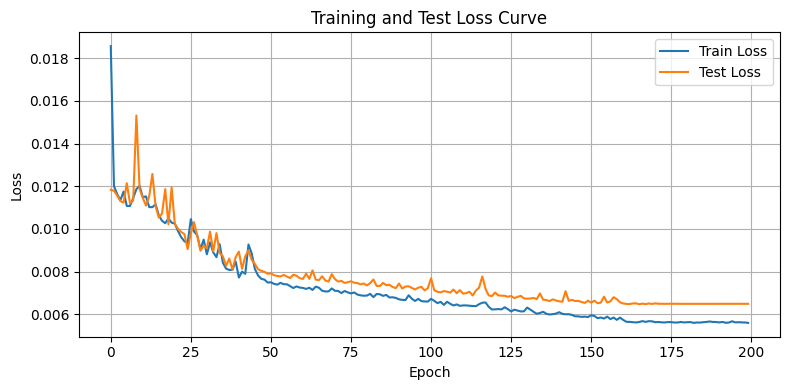

In [ ]:
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

# Set seed
torch.random.manual_seed(42)

dataset = []
for i in range(50):
    sc_subject = sc[i]
    fc_subject = fc[i]
    dataset.append({
        "subject_id": i,
        "sc": sc_subject,
        "fc": fc_subject
    })

# Convert to Graph
graph_dataset = SCGraphDataset(dataset)

# Split full dataset
train_size = int(0.7 * len(graph_dataset))
test_size = len(graph_dataset) - train_size
train_dataset, test_dataset = random_split(graph_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define model, optimizer, and loss function
model = GNNNet(layer_num=2, conv_dim=64, feature_num=116, dnn_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss(reduction='mean')

# <<< MODIFICATION 1: DEFINE THE SCHEDULER >>>
# Define the learning rate scheduler to monitor the validation loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # Reduce LR when the metric stops decreasing
    factor=0.1,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,      # Number of epochs with no improvement after which learning rate will be reduced
    # verbose=True     # Prints a message to stdout every time the learning rate is updated
)
# <<< END MODIFICATION 1 >>>

# Training
epochs = 200
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    # Your training loop remains the same
    for data in train_loader:
        optimizer.zero_grad()
        # Assuming your model call is correct for your architecture
        y_pred = model(data.x, data.edge_index, data.edge_attr, data.edge_index).squeeze()
        loss = loss_fn(y_pred, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            y_pred = model(data.x, data.edge_index, data.edge_attr, data.edge_index).squeeze()
            loss = loss_fn(y_pred, data.y)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # <<< MODIFICATION 2: UPDATE THE SCHEDULER >>>
    # The scheduler's step is called with the validation loss of the current epoch
    scheduler.step(avg_test_loss)
    # <<< END MODIFICATION 2 >>>

    # Save best model by validation loss
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1} - New best model found!")

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

# Restore best model
model.load_state_dict(best_model_state)

# save the best model
torch.save(model.state_dict(), 'GNN_116p.pth')

# Plot loss curves
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Evaluation Metrics
We evaluate the performance using **Pearson Correlation ($r$)**, the standard metric in Structure-Function coupling studies.

We define two levels of analysis:
1.  **Individual Pearson:** The correlation between Predicted FC and True FC for a single subject.
2.  **Group Pearson:** The correlation between the *average* Predicted FC and *average* True FC across the test set.

*Note: We force the diagonal of the predicted matrix to 1.0 (self-connection) to match the properties of a correlation matrix and ensure fair comparison, though typically off-diagonal elements are the focus.*

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pred_vs_true_heatmap(pred_vector, true_vector, num_nodes=3):
    """
    Plots heatmaps of predicted and true FC matrices side-by-side.

    Args:
        pred_vector (Tensor or array): Flattened predicted FC (shape: [num_nodes*num_nodes]).
        true_vector (Tensor or array): Flattened true FC (same shape).
        num_nodes (int): Number of nodes in the SC/FC matrices.
    """
    pred_matrix = pred_vector.reshape(num_nodes, num_nodes)
    true_matrix = true_vector.reshape(num_nodes, num_nodes)

    fig, axs = plt.subplots(1, 2, figsize=(32, 16))

    sns.heatmap(true_matrix, ax=axs[0], cmap='viridis', annot=False)
    axs[0].set_title("True FC")
    axs[0].set_xlabel("Region")
    axs[0].set_ylabel("Region")

    sns.heatmap(pred_matrix, ax=axs[1], cmap='viridis', annot=False)
    axs[1].set_title("Predicted FC")
    axs[1].set_xlabel("Region")
    axs[1].set_ylabel("Region")

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def plot_fc_prediction(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    r, _ = pearsonr(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label=f'Pearson r = {r:.3f}')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal: y = x')
    plt.xlabel('True FC values')
    plt.ylabel('Predicted FC values')
    plt.title('Predicted vs True FC')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def set_diagonal_inplace(pred, value=1.0):
    num_nodes = int(pred.size(0) ** 0.5)
    if pred.dim() == 1:  # flattened vector
        pred_matrix = pred.view(num_nodes, num_nodes)
        idx = torch.arange(num_nodes)
        pred_matrix[idx, idx] = value
    else:
        raise ValueError("Expected a 1D flattened FC vector.")

def calculate_pearson(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    r, _ = pearsonr(y_true, y_pred)
    return r

## 5. Performance Analysis
We calculate the Pearson $r$ on the held-out test set and visualize the predicted connectivity matrices. For reproducibility, we also provided the original weights in `models/GNN_116p.pth`

🎯 Group-Level Pearson r: 0.9499068260192871
🎯 AVG. Individual Pearson r: 0.8119090795516968


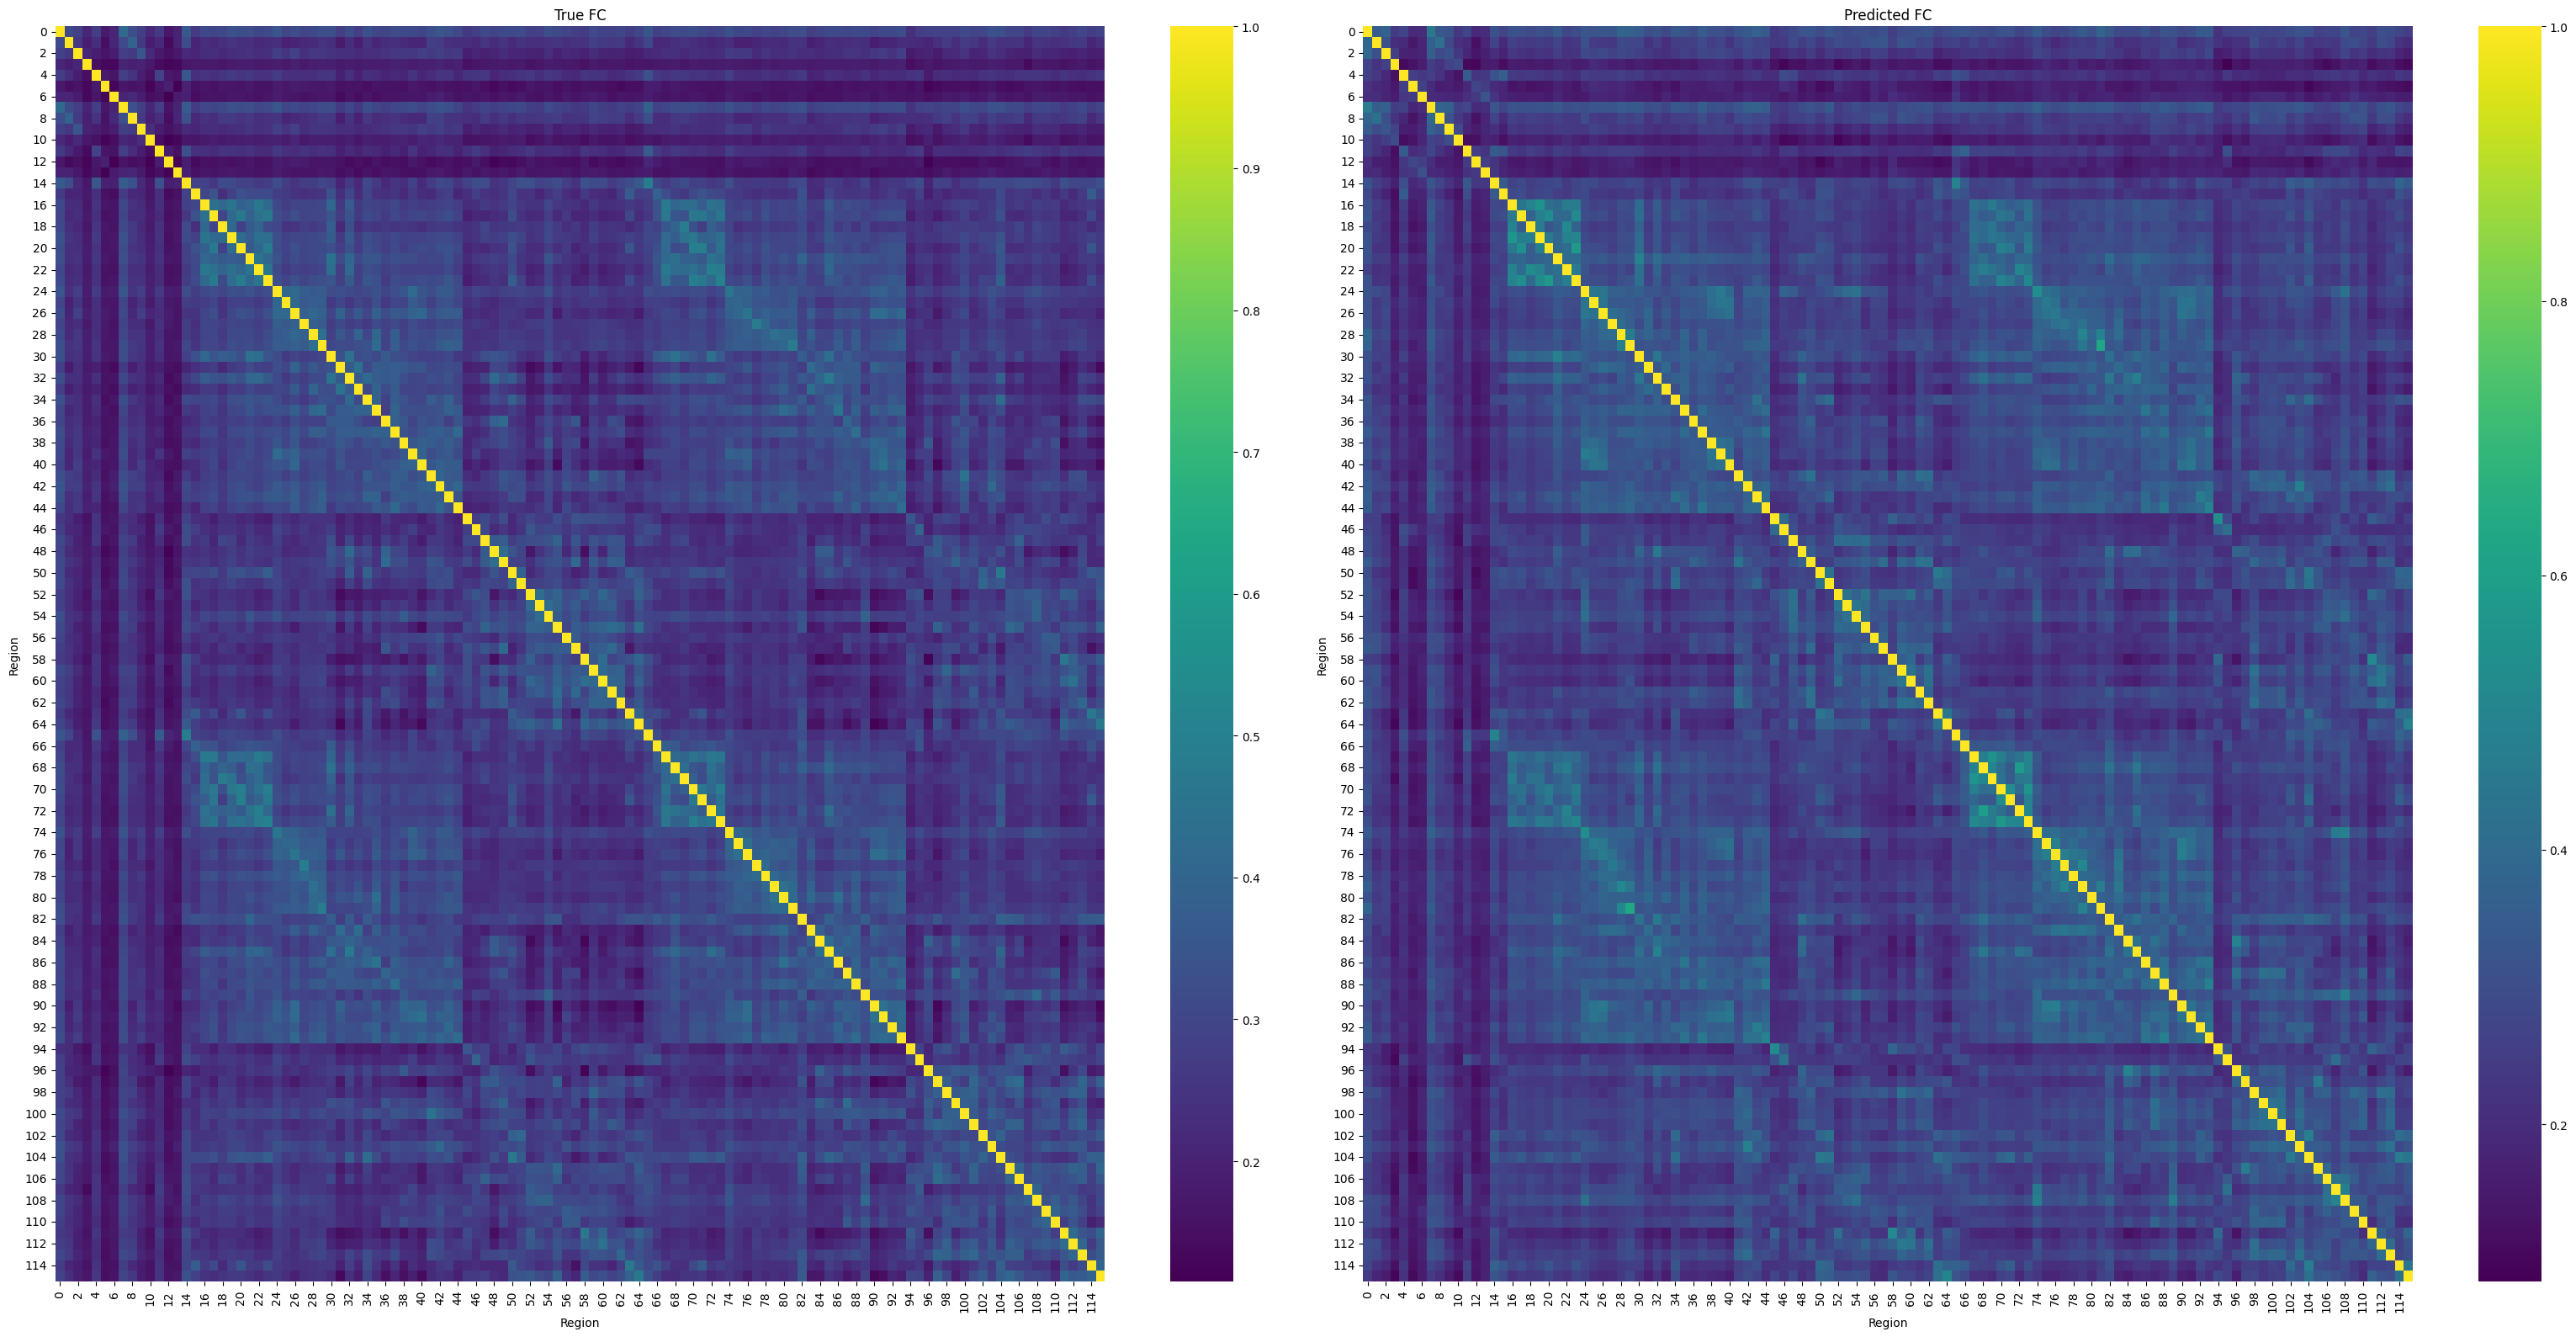

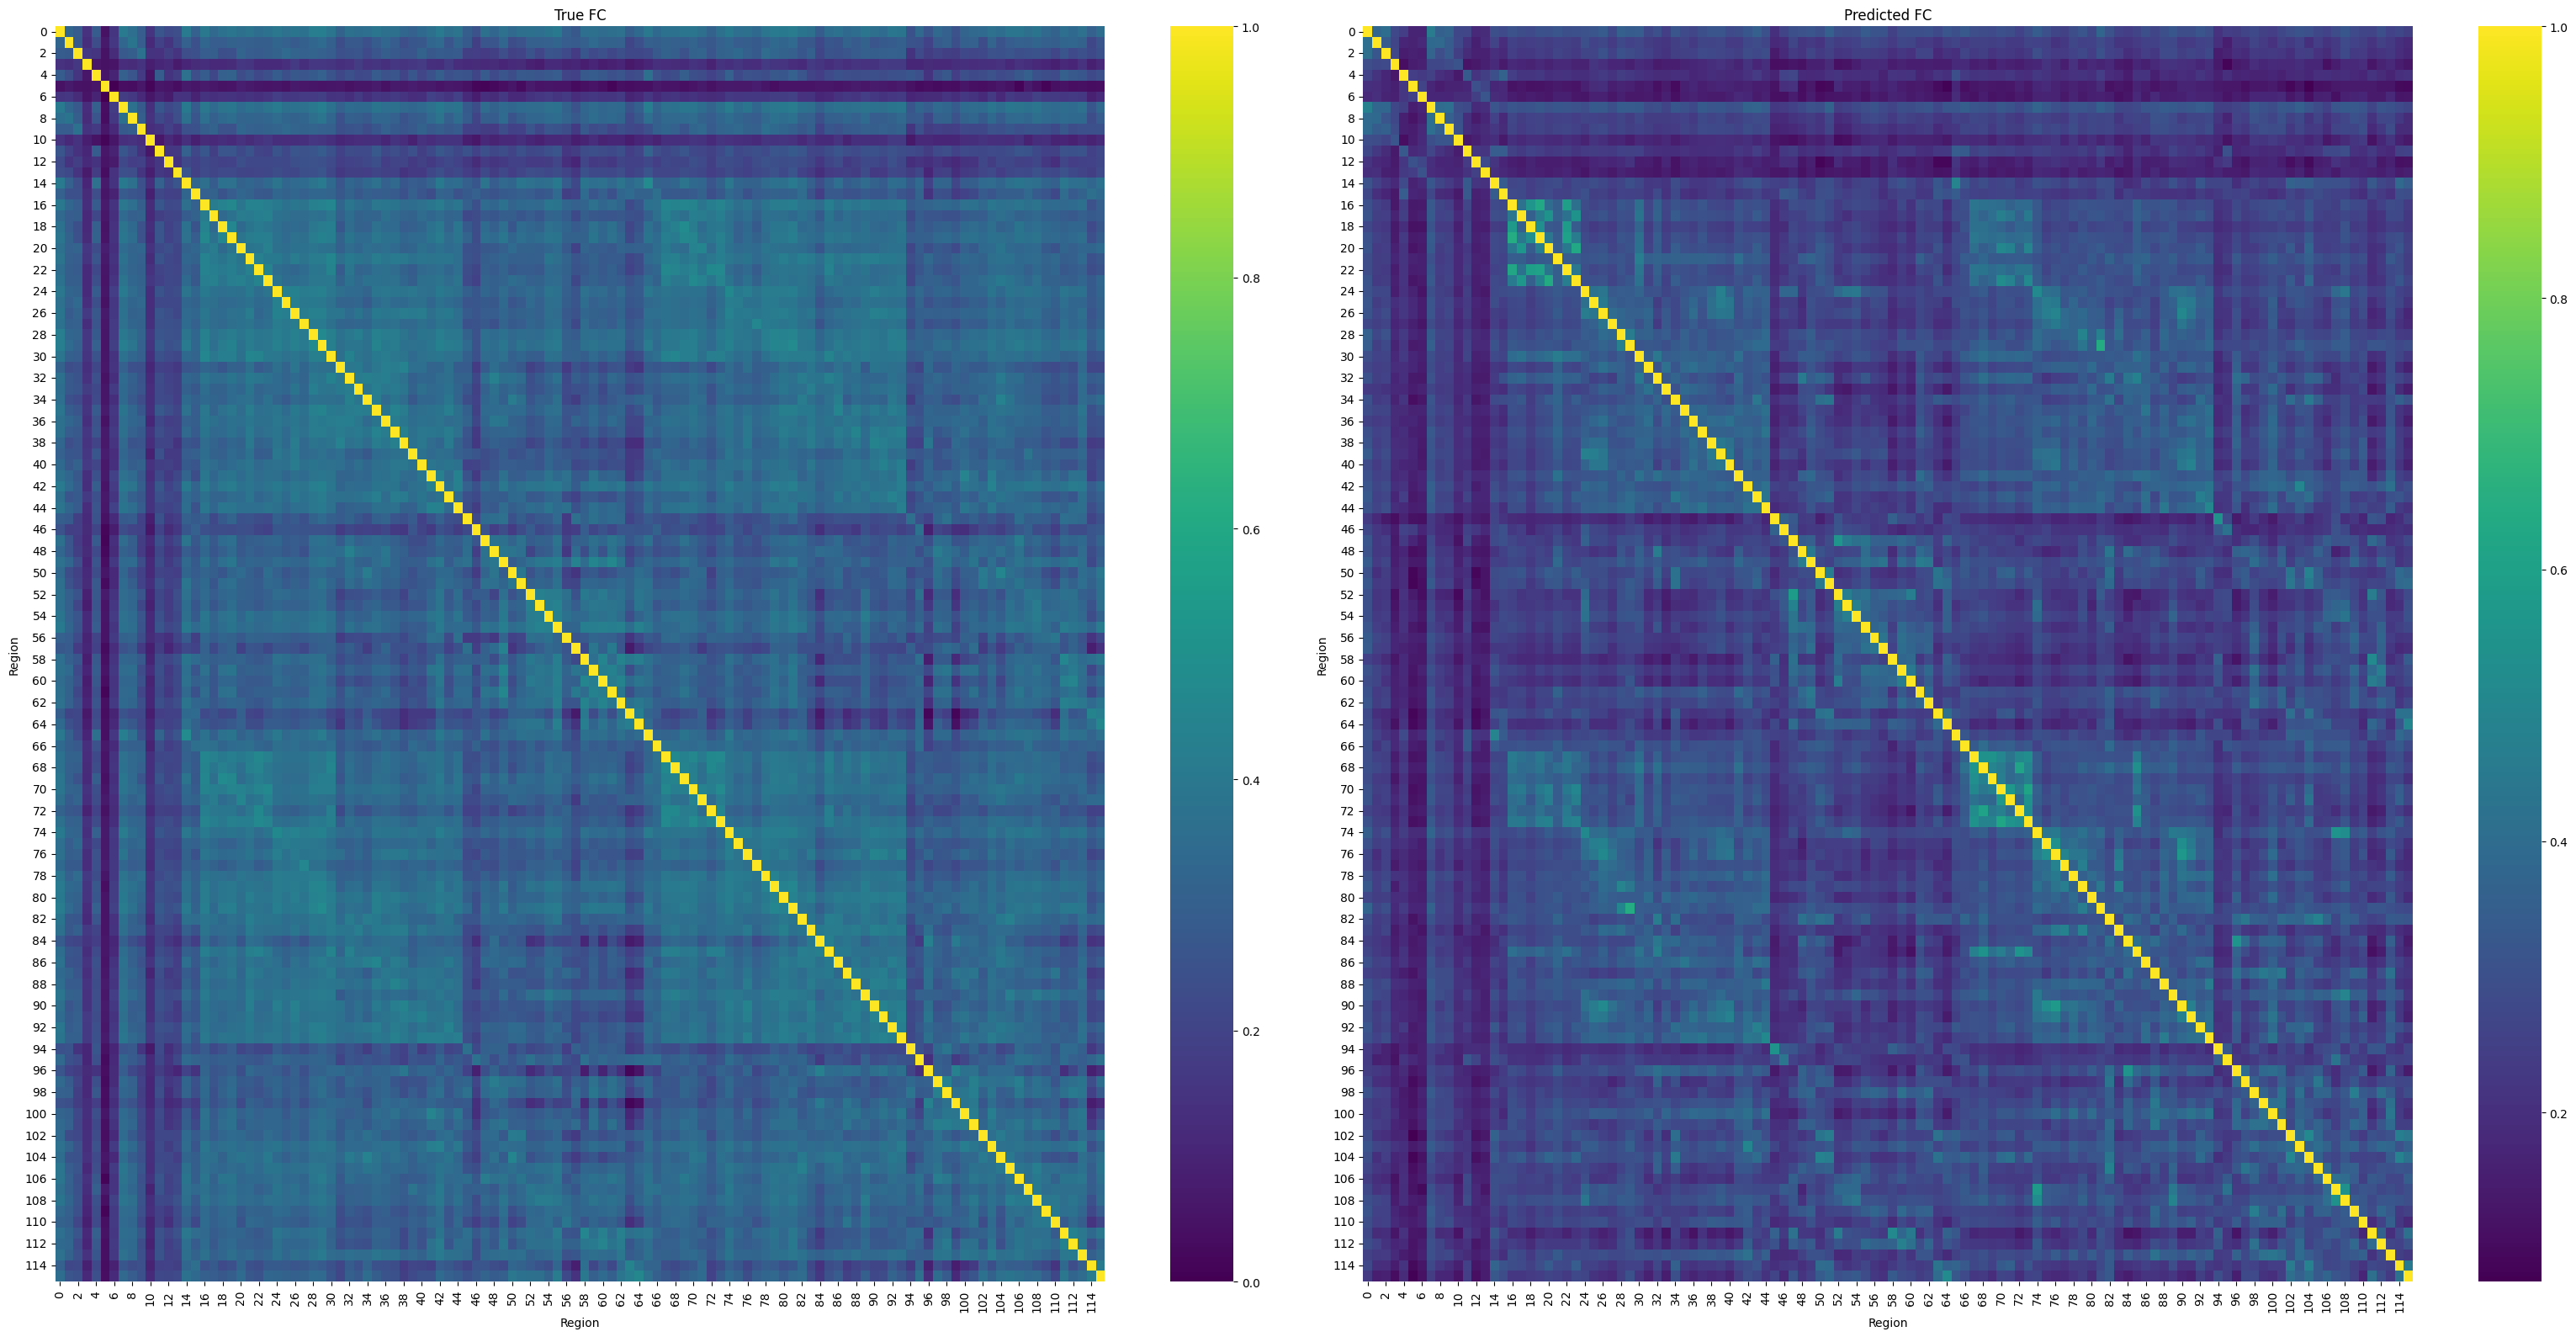

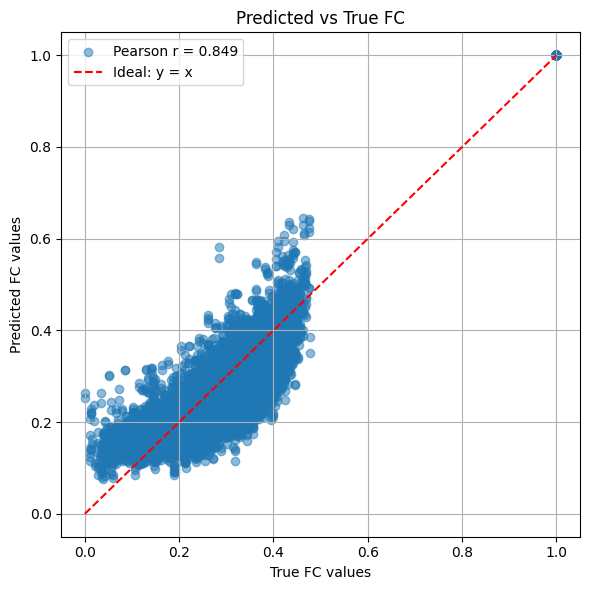

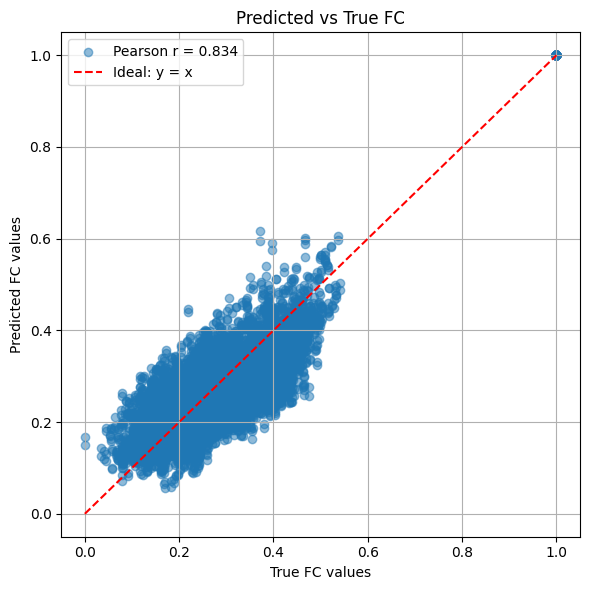

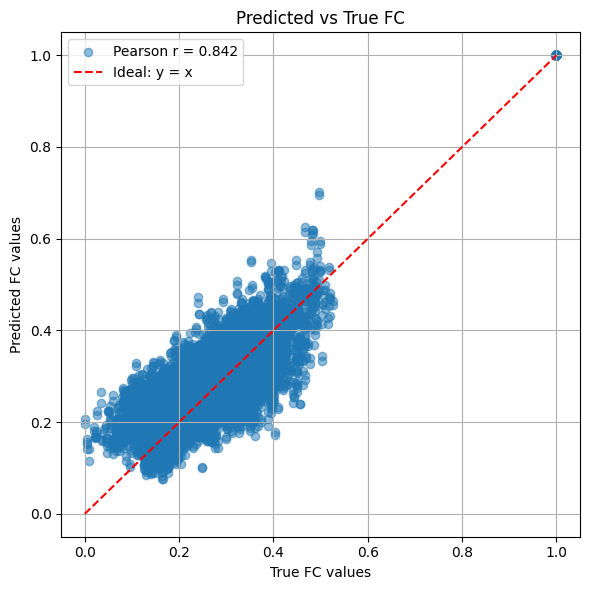

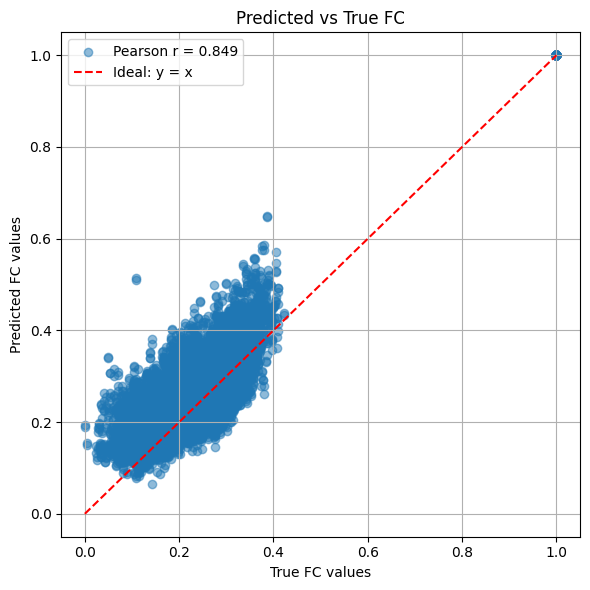

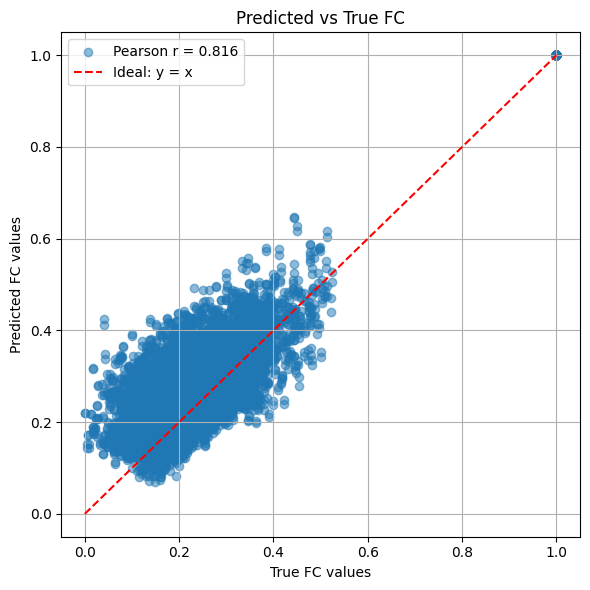

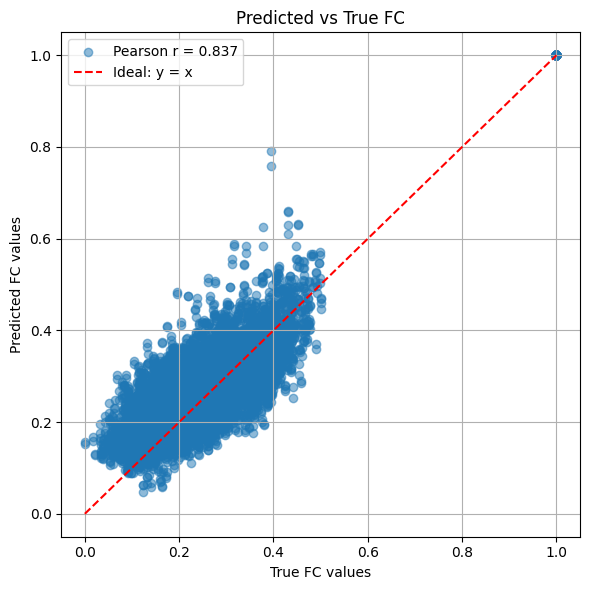

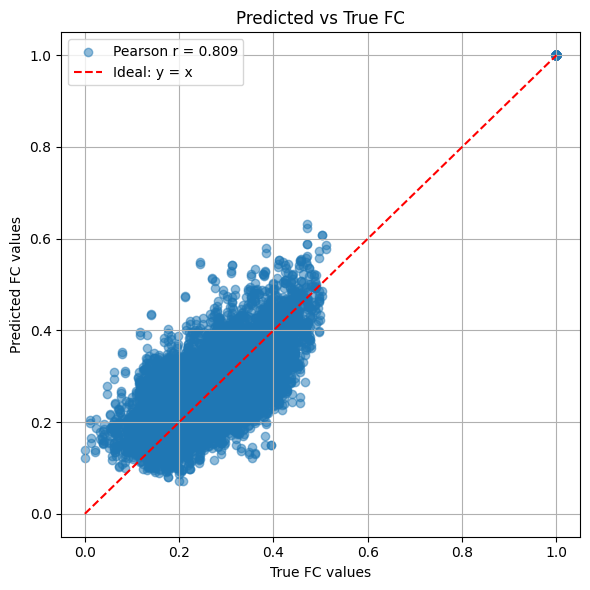

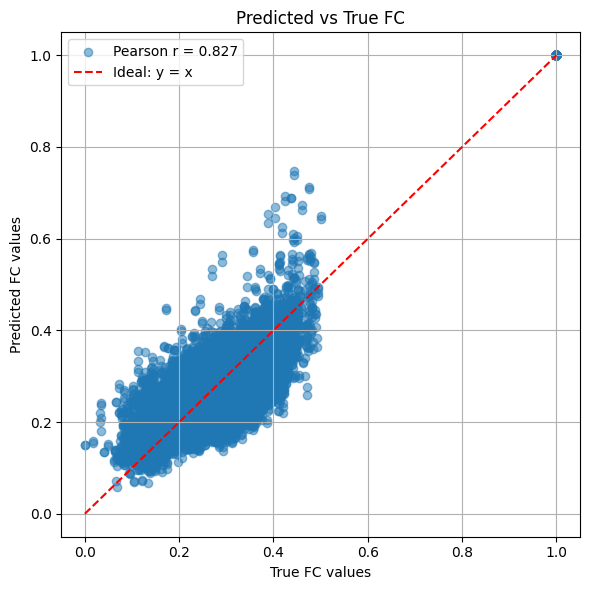

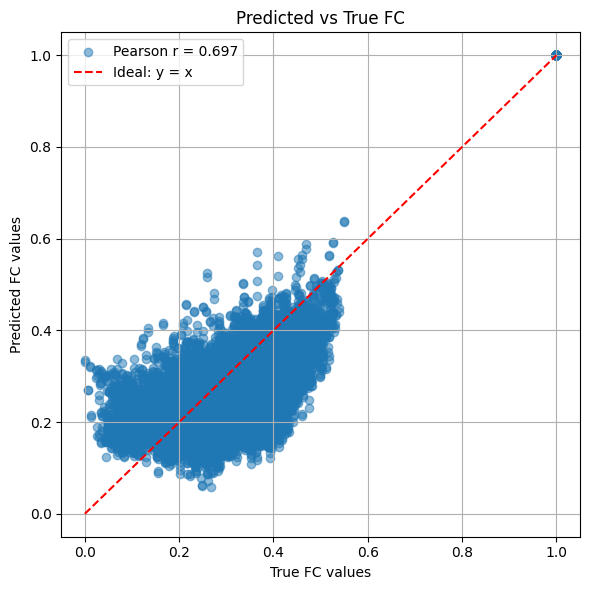

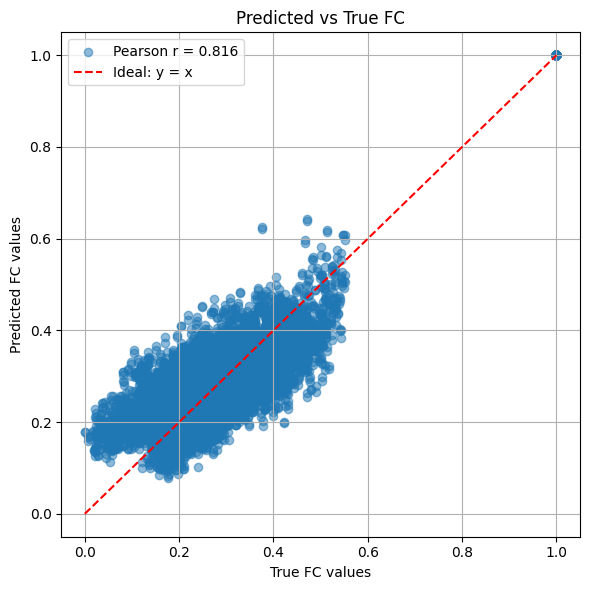

In [ ]:
model = GNNNet(layer_num=2, conv_dim=64, feature_num=116, dnn_dim=128)
model.load_state_dict(torch.load('GNN_116p.pth'))
model.eval()

# Calculate group-avg pearson r
total_pearson = 0
iter = 0

sum_preds = None
sum_trues = None


with torch.no_grad():
    for data in test_loader:
        pred = model(data.x, data.edge_index, data.edge_attr, data.edge_index).squeeze()
        # make the diagonal 1 to avoid accounting it in pearson r
        set_diagonal_inplace(pred)
        true = data.y

        # Initialize accumulators with the shape of the first matrix
        if sum_preds is None:
            sum_preds = torch.zeros_like(pred.cpu())
            sum_trues = torch.zeros_like(true.cpu())

        sum_preds += pred.cpu()
        sum_trues += true.cpu()

        total_pearson += calculate_pearson(true, pred)
        iter += 1

# Compute element-wise averages (still 2x2)
avg_pred = sum_preds / iter
avg_true = sum_trues / iter

# Flatten both matrices to vectors
avg_pred_flat = avg_pred.flatten()
avg_true_flat = avg_true.flatten()

group_pearson = calculate_pearson(avg_true_flat, avg_pred_flat)

print("================================")
print(f"🎯 Group-Level Pearson r: {group_pearson}")
print("================================")

print("================================")
print(f"🎯 AVG. Individual Pearson r: {total_pearson / iter}")
print("================================")

iter = 0
with torch.no_grad():
    for data in test_loader:
        if iter < 10:
            pred = model(data.x, data.edge_index, data.edge_attr, data.edge_index).squeeze()
            # make the diagonal 1 to avoid accounting it in pearson r
            set_diagonal_inplace(pred)
            true = data.y
            if iter == 0:
                plot_pred_vs_true_heatmap(avg_pred.cpu().numpy(), avg_true.cpu().numpy(), num_nodes=116)
                plot_pred_vs_true_heatmap(pred.cpu().numpy(), true.cpu().numpy(), num_nodes=116)
            plot_fc_prediction(true, pred)
            iter += 1
        else:
            break